# Analysing historical data from reddit 
In this notebook I will scrape historical and timestamped data from reddit utilising two different reddit api clients.
I will then analyse the data and see if there is a correlation between the sentiment of the posts and stock market prices.

I will first get all relevant urls from a specific, daily appearing post in the subreddit 'Wallstreetbets' and then then scrape all comment data from that posts.

In [159]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 300)
import praw #reddit data api
from praw.models import MoreComments # module to get replies to comments
import ffn #for loading financial data
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer #VADER sentiment model
import requests
import json
import csv
import time
import datetime
import warnings 
warnings.filterwarnings("ignore")
from tqdm import tqdm

In [161]:
#some variables used in the functions    
sub='wallstreetbets' #Subreddit to scrape
#start and end date of scraping
before = "2021-05-15"
after = "2018-01-01"
# define the thread we want to scrape every day
query = "Daily Discussion Thread"
subStats = []
subCount = 0


#function to get reddit post titles and urls with timestamp from pusshift api
def getPushshiftData(query, after, before, sub):
    url = ('https://api.pushshift.io/reddit/search/submission/?title='
           +str(query)+'&size=10000&after='+str(after)+'&before='+str(before)+'&subreddit='+str(sub)) # get Pusshift url
    r = requests.get(url) # get request
    data = json.loads(r.text) # load data into a json file
    return data['data'] # return part of the json file


#get needed data from data scraped above
def collectPosts(post):
    subData = ([post['id'], post['title'], post['url'], 
                datetime.datetime.fromtimestamp(post['created_utc']).date()]) #create list to hold data about posts
    try:
        flair = post['link_flair_text'] # try to get flair of the post
    except KeyError:
        flair = "NaN" # if there is no flai return NaN
    subData.append(flair) # append flair
    subStats.append(subData) # append data 

    
data = getPushshiftData(query, after, before, sub) # get data


# loop will run until all posts have been gathered 
# from the 'after' date up until before date
while len(data) > 0:
    for submission in data:
        collectSubData(submission)
        subCount+=1
    # Calls getPushshiftData() with the created date of the last submission
    after = data[-1]['created_utc']
    data = getPushshiftData(query, after, before, sub)
    

#organize data into dataframe
# create variables
data={} # dictionary in preperation for dataframe
# lists that will contain column values
ids=[]
titles=[]
urls=[]
dates=[]
flairs=[]

# get data into variables
for stat in subStats:
    ids.append(stat[0])
    titles.append(stat[1])
    urls.append(stat[2])
    dates.append(stat[3])
    flairs.append(stat[4])

# append dictionary    
data['id']=ids
data['title']=titles
data['url']=urls
data['date']=dates
data['flair']=flairs

# create dataframe from dictionary

posts=pd.DataFrame(data)
posts=posts[posts['flair']=='Daily Discussion']
posts

,id,title,url,date,flair
162,9660mi,"Daily Discussion Thread - August 10, 2018",https://www.reddit.com/r/wallstreetbets/commen...,2018-08-10,Daily Discussion
165,97hd9r,"Daily Discussion Thread - August 15, 2018",https://www.reddit.com/r/wallstreetbets/commen...,2018-08-15,Daily Discussion
168,98sook,"Daily Discussion Thread - August 20, 2018",https://www.reddit.com/r/wallstreetbets/commen...,2018-08-20,Daily Discussion
171,99mgws,"Daily Discussion Thread - August 23, 2018",https://www.reddit.com/r/wallstreetbets/commen...,2018-08-23,Daily Discussion
173,9ao1di,"Daily Discussion Thread - August 27, 2018",https://www.reddit.com/r/wallstreetbets/commen...,2018-08-27,Daily Discussion
...,...,...,...,...,...
993,n90t4p,"Daily Discussion Thread for May 10, 2021",https://www.reddit.com/r/wallstreetbets/commen...,2021-05-10,Daily Discussion
994,n9th6n,"Daily Discussion Thread for May 11, 2021",https://www.reddit.com/r/wallstreetbets/commen...,2021-05-11,Daily Discussion
995,nal19o,"Daily Discussion Thread for May 12, 2021",https://www.reddit.com/r/wallstreetbets/commen...,2021-05-12,Daily Discussion
996,nbd3jq,"Daily Discussion Thread for May 13, 2021",https://www.reddit.com/r/wallstreetbets/commen...,2021-05-13,Daily Discussion


In [162]:
# setting up redit client to scrape comments of the posts with PRAW
reddit = praw.Reddit(
  client_id = "dlY27DaxJQaL5Q",
  client_secret = "z-MStmsM-inT4-XJmeGtovN05XCEgw",
  user_agent = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36"
)

In [163]:
daily_comments=[] # list that will hold lists of daily comments
for url in tqdm((posts['url'].tolist())): # iterate over urls
    try:
        comments = []
        submission = reddit.submission(url=url) # get comments
        submission.comments.replace_more(limit=0) # this PRAW function allows to access comments and replies 
        for comment in submission.comments: #
            comments.append(comment.body) # append comments and replies to list
        daily_comments.append(comments)
    except:
        comment=None
        comments.append(comment)
        

100%|██████████| 505/505 [28:46<00:00,  3.42s/it]


In [166]:
len(daily_comments)


505

### We now have all comments from each day in a list. Next I will apply VADER sentiment score to the comments
I will then sum up the sentiment scores to create a sentiment score for the day

In [167]:
sia = SentimentIntensityAnalyzer() # import vader sentiment analyzer

scores=[] # list that will hold scores
for comments in tqdm(daily_comments): # iterate over comments by day, a list that holds lists
    sentiment_score=0
    try:
        for comment in comments: # iterate over every comment of every day
            sentiment_score=sentiment_score+sia.polarity_scores(comment)['compound'] # get compund score of comments
        scores.append(sentiment_score) # append to scores list
    except TypeError: #when error occurs
        sentiment_score=0 # set score to zero for the day
        scores.append(sentiment_score) # append score to the scores list
    
posts['sentiment score']=scores

100%|██████████| 505/505 [00:16<00:00, 30.48it/s]


In [168]:
#posts = posts.drop_duplicates(subset = 'date', keep = 'first')
posts['date'] = posts['date'].astype(str)

## Merge sentiment data with spy price
I will use spy etf, the worlds largest index fund, as my benchmark, since it reflects to the largest markets wallstreetbets talks about

In [174]:
spy=ffn.get('spy', start='2018-01-01') # get spy prices from 01.01.2018
spy['date'] = spy.index.astype(str) # convert date to string 
sent_vals = []

In [175]:
# check if date is in one of the scraped dates, if yes, append to sent_vals
sentiment_df = pd.DataFrame() 
for index, row in posts.iterrows(): # iterate over posts df
    if row[3] in spy['date'].tolist(): # if date is also in spy price table
        temp = spy.loc[spy['date'] == row[3]] # create new table that contains the row of the current iteration
        temp['sent'] = row[5] # update sentiment score for that row
        sentiment_df = sentiment_df.append(temp) # append it to new dataframe        

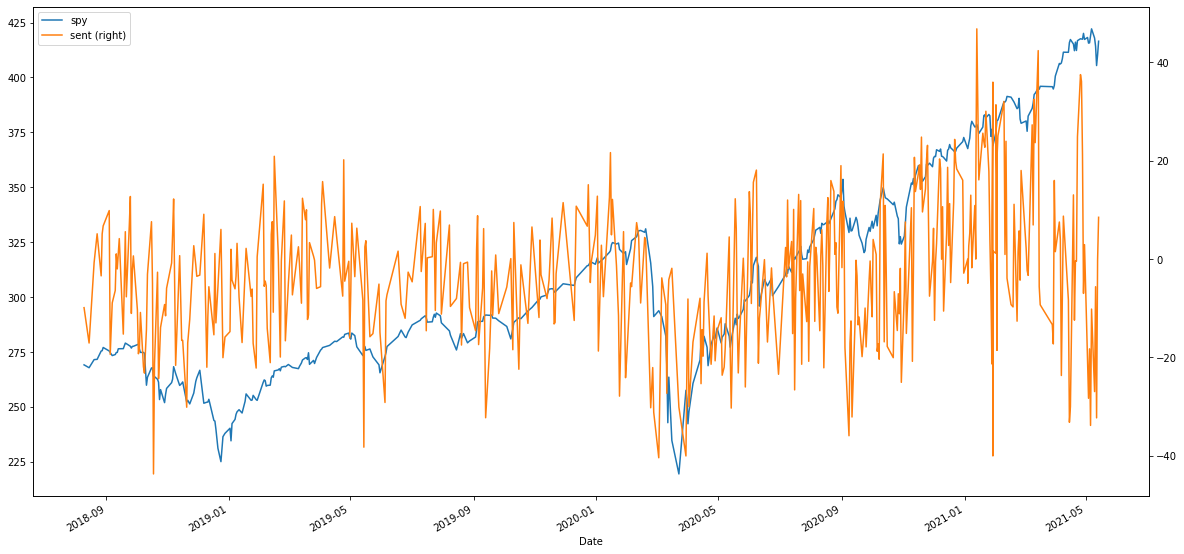

In [176]:
sentiment_df.plot(secondary_y='sent', figsize=(20, 10));

# Fourier transform of sentiment scores to reduce noise

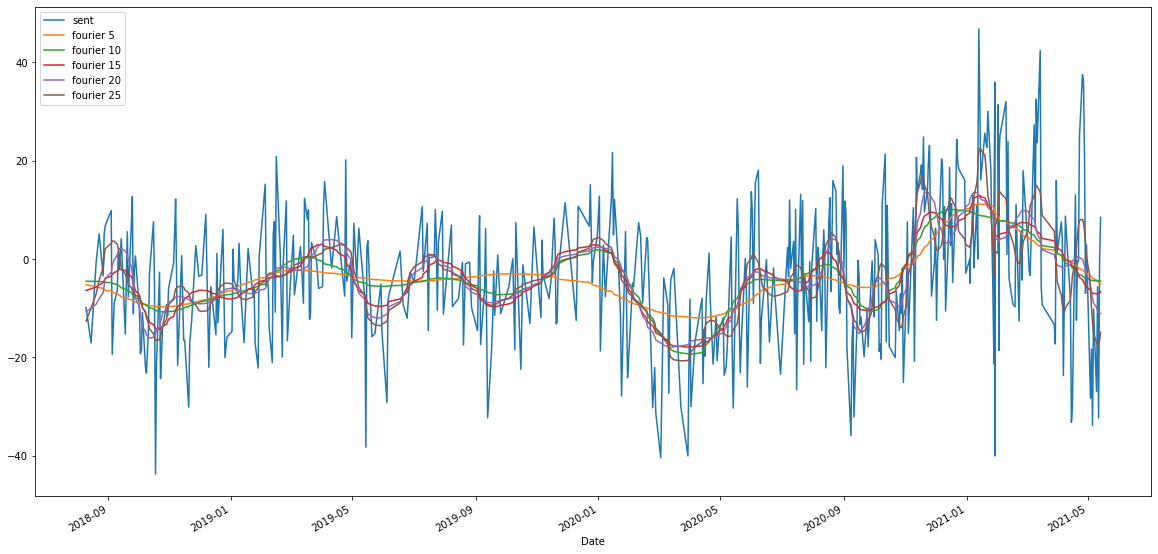

In [177]:
price_fourier = np.fft.fft(np.asarray(sentiment_df['sent'].tolist())) # extract sentiment score as a discrete fourier transform
fourier_df = pd.DataFrame({'fourier':price_fourier}) # prepare dataframe
fourier_df['absolute'] = fourier_df['fourier'].apply(lambda x: np.abs(x)) # return absolute value
fourier_df['angle'] = fourier_df['fourier'].apply(lambda x: np.angle(x)) # return the angle of the complex argument.

fourier_list = np.asarray(fourier_df['fourier'].tolist())

for num_ in range(5,30,5):
    fourier_list_m10= np.copy(fourier_list); fourier_list_m10[num_:-num_]=0 # calculate fourier
    sentiment_df['fourier '+str(num_)]=np.fft.ifft(fourier_list_m10) # append each fourier to dataframe with name of fourier
    
sentiment_df[['sent', 'fourier 5', 'fourier 10', 'fourier 15', 'fourier 20', 'fourier 25']].plot(figsize=(20, 10));


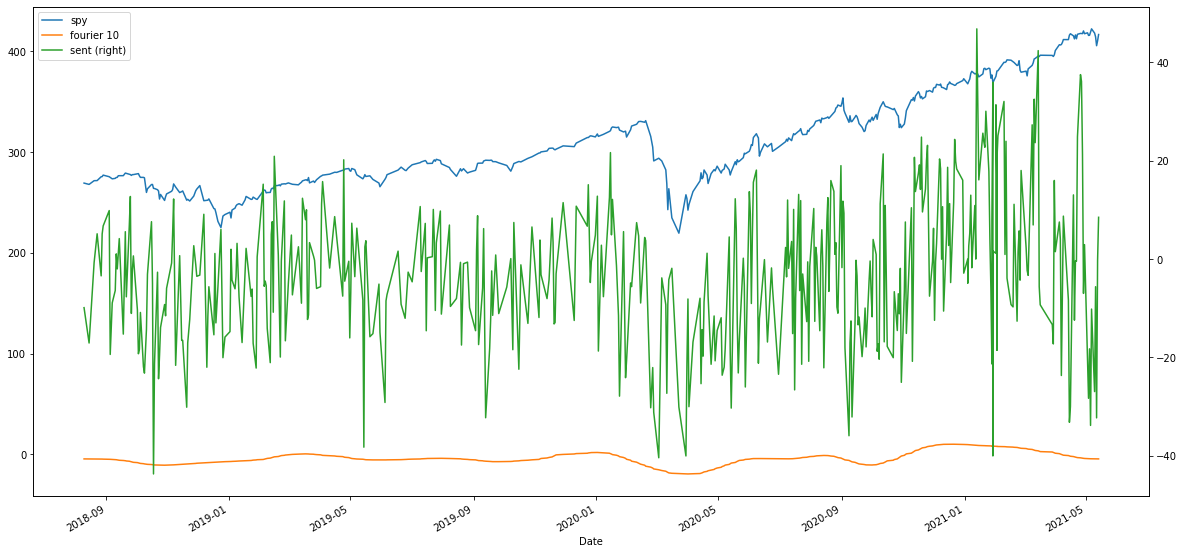

In [183]:
sentiment_df[['spy', 'fourier 10', 'sent']].plot(secondary_y='sent', figsize=(20, 10));

In [185]:
sentiment_df.to_csv('sentiment.csv', index = False)